# Imports

In [1]:
from scipy.spatial.distance import pdist, squareform
from itertools import combinations, groupby
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import rv_continuous
from numpy import pi, cos, sin, tan
from collections import Counter

import os
import time
import scipy
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import ringity as rng
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

In [2]:
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: left;
}
</style>
"""))

# Plot parameters

In [3]:
def pre_comb(x):
    return x*(1-np.linalg.norm(x)/np.sqrt(2))

def comb(pos): 
    return {k:pre_comb(v) for (k,v) in pos.items()}

In [4]:
cemm1 = [0/255,85/255,100/255]
cemm2 = [0/255,140/255,160/255]
cemm3 = [64/255,185/255,212/255]
cemm4 = [212/255,236/255,242/255]

costume = [0/255,9/255,10/255]

sblue = sns.color_palette()[0]
sred = sns.color_palette()[1]
sgreen = sns.color_palette()[2]
sblack = sns.color_palette('bright')[7]
sblack2 = sns.color_palette('dark')[7]

In [5]:
node_col = cemm1
edge_col = cemm2

def plot_nx(G, 
            pos=None, 
            ax=None, 
            name='nx.pdf', 
            node_colors = None,
            node_alpha  = 0.3, 
            edge_colors = None,
            edge_alpha  = 0.2,
            path=None, 
            silence=False,
            **kwargs):

    if pos is None:
        pos = nx.spring_layout(G)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8));
        fig.patch.set_alpha(0)
    if node_colors is None:
        node_colors = [node_col for v in G.nodes]
    if edge_colors is None:
        edge_colors = [edge_col for u,v in G.edges]
    nodes = nx.draw_networkx_nodes(G, pos=pos, alpha=node_alpha, ax=ax, node_color=node_colors, node_size=15, linewidths=1)
    edges = nx.draw_networkx_edges(G, pos=pos, alpha=edge_alpha, ax=ax, edge_color=edge_colors)
    ax.axis('off');
    
    if path is None:
        path = f'dummy/{name}'
    plt.savefig(path, transparent=True, **kwargs);
    
    if silence:
        plt.close()
    
    
def plot_dgm(dgm, ax=None, name='dgm.pdf', path=None, silence=False, **kwargs):
    x,y = zip(*[(k.birth,k.death) for k in dgm])
    d = max(y)

    if ax is None:
        fig, ax = plt.subplots()
        fig.patch.set_alpha(0)

    ax.patch.set_alpha(0)
    
    hw = 0.025 # head width of the arrow
    
    ax.set_xlim([-hw, d*1.1])
    ax.set_ylim([-hw, d*1.1])
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color(sblack2)
    
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color(sblack2)

#     xmin, xmax = ax.get_xlim() 
#     ymin, ymax = ax.get_ylim()
    
#     ax.arrow(0, 0, 0, d, head_width=hw, head_length=2*hw, fc=sblack2, ec=sblack2, linewidth=2.5)
#     ax.arrow(0, 0, d, 0, head_width=hw, head_length=2*hw, fc=sblack2, ec=sblack2, linewidth=2.5)

#     ax.set_xlabel('Time of birth')
#     ax.set_ylabel('Time of death')

    ax.plot(x, y, '*', markersize=5, color = cemm2);
    ax.plot([0,d],[0,d], color= [c/2 for c in cemm1], linewidth=1, linestyle='dashed');

    if path is None:
        path = f'dummy/{name}'
    plt.savefig(path, **kwargs)
    
    if silence:
        plt.close()
    

def plot_bar(dgm, ax=None, cap=None, name='bar.pdf', path=None, silence=False, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)
    else:
        ax.patch.set_alpha(0)
    if cap is not None:
        for i in range(cap): dgm.append((0,0))
    bar = rng.normalized_barcode(dgm)[:cap]
    ax.bar(range(len(bar)), bar, color=sblack);
    
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color(sblack2)
    
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color(sblack2)
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    
#     hw = 0.025 # head width of the arrow
    
#     xmin, xmax = ax.get_xlim() 
#     ymin, ymax = ax.get_ylim()
    
#     ax.arrow(0, 0, 0 , 1/1.1, head_width=hw, head_length=2*hw, fc=sblack2, ec=sblack2, linewidth=2.5)
#     ax.arrow(0, 0, 30/1.1, 0, head_width=hw, head_length=2*hw, fc=sblack2, ec=sblack2, linewidth=2.5)
    
    if path is None:
        path = f'dummy/{name}'
    plt.savefig(path, **kwargs)
    
    if silence:
        plt.close()
    

def write_summary(G, dgm=None, name='summary.html', induce=True, path=None):
    if dgm is None:
        dgm = rng.diagram(G, induce=True)
        
    string = f"""
<!DOCTYPE html>
<html>
<body>
<font size="+20">
<center><h1> Graph Summary </h1>
<table>
    <tr>
        <th></th>
        <th width="20%"></th>
        <th></th>
    </tr>
    <tr>
        <td><strong>N</strong></td>
        <td align="center"> = </td>
        <td>{G.number_of_nodes()}</td>
    </tr>
    <tr>
        <td><strong>E</strong></td>
        <td align="center"> = </td>
        <td>{G.number_of_edges()}</td>
    </tr>
    <tr>
        <td><strong>p</strong></td>
        <td align="center"> = </td>
        <td>{round(nx.density(G),6)}</td>
    </tr>
    <tr>
        <td><strong>GGS</strong></td>
        <td align="center"> = </td>
        <td>{round(dgm.GGS, 6)}</td>
    </tr>
    <tr>
        <td><strong>SPL</strong><sub>avg</sub></td>
        <td align="center"> = </td>
        <td>{round(nx.average_shortest_path_length(G), 6)}</td>
    </tr>
    <tr>
        <td><strong>C</strong><sub>avg</sub></td>
        <td align="center"> = </td>
        <td>{round(nx.average_clustering(G), 6)}</td>
    </tr>
</table>
</font>
</body>
</html>
""" 
    if path is None:
        path = f'dummy/{name}'
    
    with open(path, 'w') as f:
        f.write(string)

# Geometric networks

In [6]:
seed = 11092018

## Annulus

In [7]:
# functions needed
@np.vectorize
def half_circ(x, r=1):
    return np.sqrt(r**2 - x**2)

def annulus(N, 
            r = 1, 
            seed = None):
    """ Outside radius is taken to be 1"""
    
    np.random.seed(seed=seed)
    u,v = np.random.uniform(0,1,[2,N])
    
    phi = 2*np.pi*u
    r = np.sqrt((1-r**2)*v + r**2)
    
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    
    return x,y

In [8]:
# sample preprocessing
N = 200
r = 0.5

pts = annulus(N=N, r=r, seed=seed)

x_in  = np.linspace(-r,r, 101)
x1 = np.stack((x_in, -x_in)).flatten()
y1 = np.stack((half_circ(x_in, r),-half_circ(x_in, r))).flatten()

x_out = np.linspace(-1,1, 101)
x2 = np.stack((x_out,-x_out)).flatten()
y2 = np.stack((half_circ(x_out),-half_circ(x_out))).flatten()

x_left  = np.linspace(-1,-r, 101)
x_mid   = np.linspace(-r, r, 101)
x_right = np.linspace( r, 1, 101)

phi = np.linspace(-pi,pi,101)
x = (r+0.01)*cos(phi)
y = (r+0.01)*sin(phi)

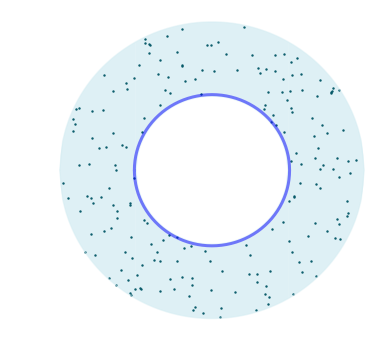

In [9]:
# sampling visual
geo_fig = plt.figure(figsize=(6,6));
ax  = geo_fig.gca();
ax.axis('off');

ax.plot(pts[0], pts[1], 'o', markersize=1.5, color=cemm1, alpha=0.8);

ax.plot(x1, y1, color=cemm4, alpha=0.5);
ax.plot(x2, y2, color=cemm4, alpha=0.5);
ax.plot(x, y, color='blue', alpha=0.5, linewidth=3);

ax.fill_between(x_left, -half_circ(x_left)  , half_circ(x_left),  alpha=0.75, facecolor=cemm4, edgecolor="none");
ax.fill_between(x_mid,   half_circ(x_mid, r), half_circ(x_mid),   alpha=0.75, facecolor=cemm4, edgecolor="none");
ax.fill_between(x_mid,  -half_circ(x_mid, r),-half_circ(x_mid),   alpha=0.75, facecolor=cemm4, edgecolor="none");
ax.fill_between(x_right, half_circ(x_right) ,-half_circ(x_right), alpha=0.75, facecolor=cemm4, edgecolor="none");

In [10]:
# network preprocessing
d = 0.5

D = squareform(pdist(np.array(pts).T))
A = np.where(np.abs(D)>d,0,1)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


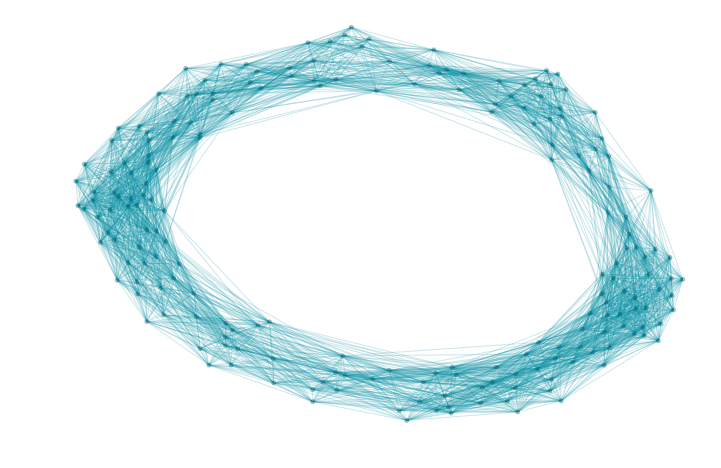

In [11]:
# network visuals
plot_nx(G, pos=pos)

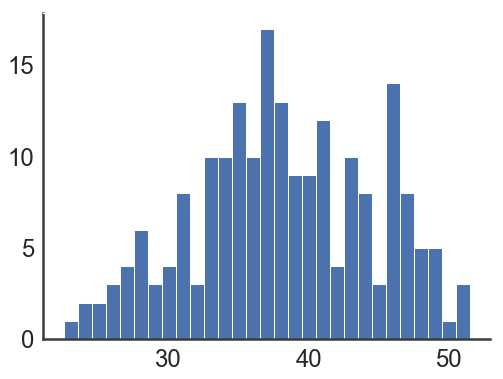

In [13]:
mode = 'bar'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, width=1, color=sblue)");

# ax.set_xlabel('degree', fontsize=24)
# ax.set_ylabel('frequency', fontsize=24)
# ax.set_title('Annulus degree distribution', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

# deg_fig.savefig(f'google_drive/annulus/annulus_r{r:.2f}_d{d:.2f}_deg_{mode}.pdf', transparent=True)

In [14]:
# calclulate diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_d = rng.diagram(G, toa='toa')

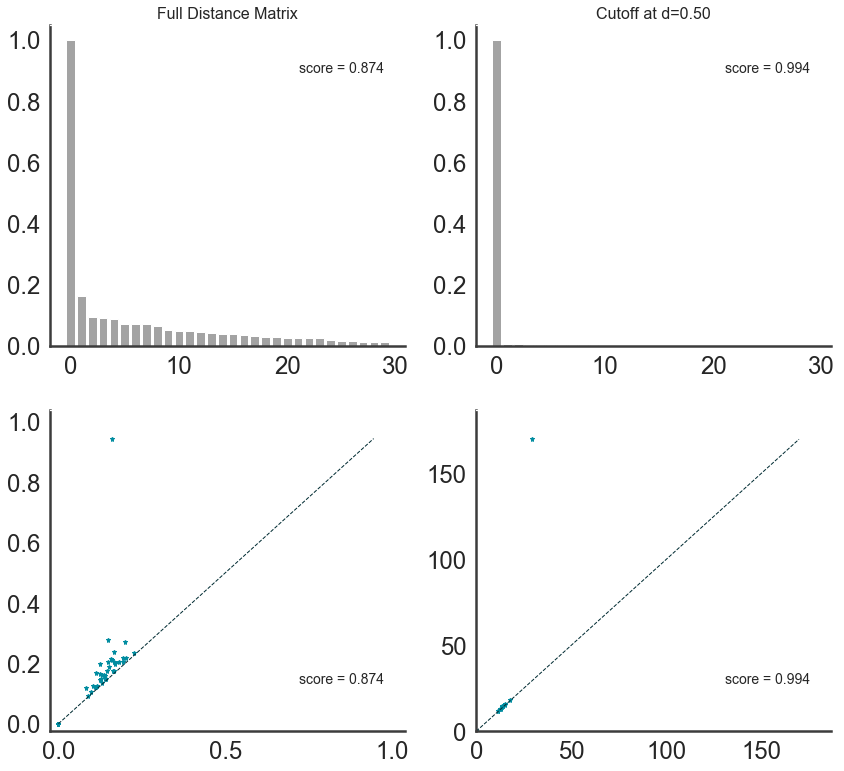

In [15]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at d={d:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=30)
plot_bar(dgm_d, ax=axes[0,1], cap=30)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_d, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);

In [18]:
dgm = rng.Dgm()
for i in range(14):
    dgm.append([1,2])

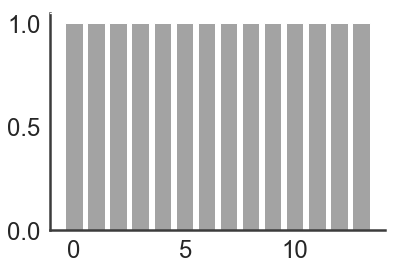

In [20]:
plot_bar(dgm)
plt.savefig('test.png')

### Save Data

In [19]:
# save data
np.savetxt(f'data/toy_networks/annulus/annulus_r{r:.2f}_D.txt', D)

dgm.save(  f'data/toy_networks/annulus/annulus_r{r:.2f}_dgm.csv')
dgm_d.save(f'data/toy_networks/annulus/annulus_r{r:.2f}_dgm_d.csv')

nx.write_edgelist(G, f'data/toy_networks/annulus/annulus_r{r:.2f}_d{d:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/toy_networks/annulus/annulus_r{r:.2f}_d{d:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_d, path=f'data/toy_networks/annulus/annulus_r{r:.2f}_d{d:.2f}_summary.html')

In [20]:
# save visuals
plot_dgm(dgm, path=f'data/toy_networks/annulus/annulus_r{r:.2f}_dgm.pdf', silence=True, frameon=False, transparent=True)
plot_bar(dgm, path=f'data/toy_networks/annulus/annulus_r{r:.2f}_bar.pdf', silence=True, cap=30, transparent=True)

plot_dgm(dgm_d, path=f'data/toy_networks/annulus/annulus_r{r:.2f}_d{d:.2f}_dgm.pdf', silence=True, transparent=True)
plot_bar(dgm_d, path=f'data/toy_networks/annulus/annulus_r{r:.2f}_d{d:.2f}_bar.pdf', silence=True, cap=30, transparent=True)
plot_nx(G,      path=f'data/toy_networks/annulus/annulus_r{r:.2f}_d{d:.2f}_nx.pdf',  silence=True, pos=pos)

geo_fig.savefig(f'data/toy_networks/annulus/annulus_r{r:.2f}_geometry1.pdf', transparent=True)
deg_fig.savefig(f'data/toy_networks/annulus/annulus_r{r:.2f}_d{d:.2f}_deg.pdf', transparent=True)

## Cylinder

In [28]:
# functions needed
def cylinder(N,
             height = 1,
             seed = None):
    
    np.random.seed(seed=seed)
    u,v = np.random.uniform(0,1,[2,N])
    
    phi = 2*np.pi*u
    
    x = np.cos(phi)
    y = np.sin(phi)
    z = np.random.uniform(0,height,N)
    
    return x,y,z

In [29]:
# sample preprocessing
N = 500
h = 3

pts = cylinder(N=N, height=h, seed=seed)

phi    = np.linspace(0, 2*np.pi, 101)
height = np.linspace(0, h, 101)

x = np.outer(np.cos(phi), np.ones(101))
y = np.outer(np.sin(phi), np.ones(101))
z = np.outer(np.ones(101), height)

phi = np.linspace(0,2*pi,101)
x1 = cos(phi)
y1 = sin(phi)
z1 = h/2 * np.ones_like(phi)

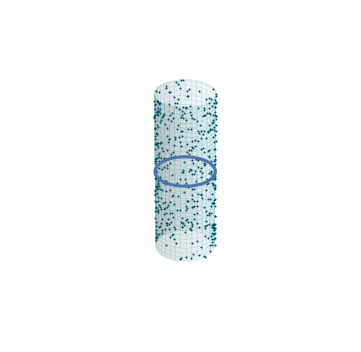

In [30]:
# sampling visual
geo_fig = plt.figure(figsize=(6,6))
ax  = geo_fig.gca(projection='3d')
ax.set_xlim(-h,h)
ax.set_ylim(-h,h)
ax.set_zlim(0,h)
ax.set_facecolor('white')
ax.axis('off')

ax.plot(pts[0],pts[1], pts[2], 'o', markersize=1, color=cemm1);
ax.plot_surface(x, y, z, color=cemm4, alpha=0.25, linewidth=0.1, edgecolors=cemm2 + [0.5]);
ax.plot(x1, y1, z1, 'b', linewidth=3);

In [31]:
# network preprocessing
d = 0.75

D = squareform(pdist(np.array(pts).T))
A = np.where(np.abs(D)>d,0,1)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G)

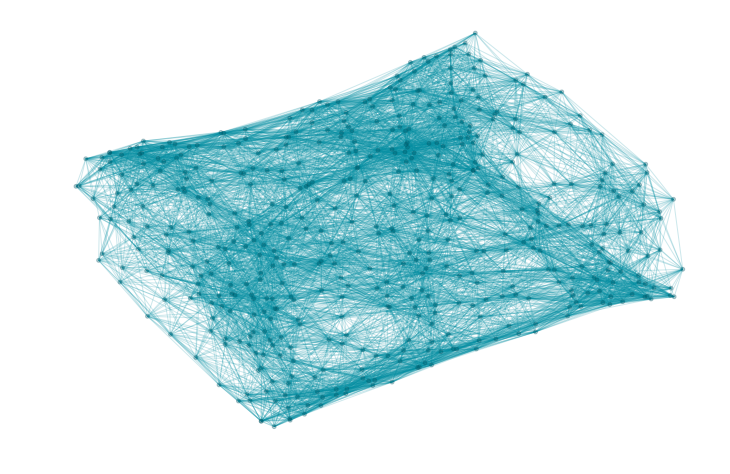

In [32]:
# network visuals
plot_nx(G, pos=pos)

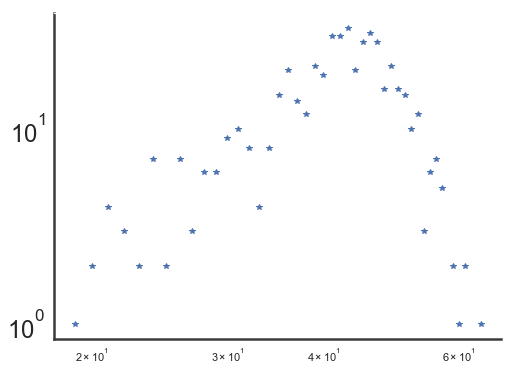

In [36]:
mode = 'loglog'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, '*', color=sblue)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)


deg_fig.savefig(f'google_drive/cylinder/cylinder_h{h:.2f}_d{d:.2f}_deg_{mode}.pdf', transparent=True)

In [27]:
# calclulate diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_d = rng.diagram(G, toa='toa')

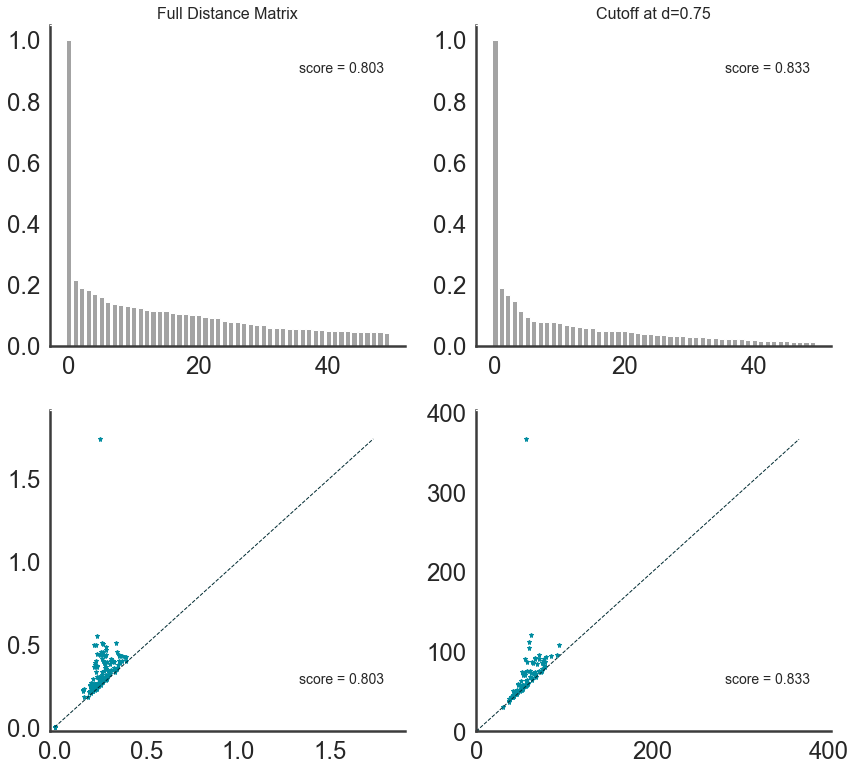

In [28]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at d={d:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_d, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_d, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);

### Save Data

In [29]:
# save data
np.savetxt(f'data/toy_networks/cylinder/cylinder_h{h:.2f}_D.txt', D)

dgm.save(  f'data/toy_networks/cylinder/cylinder_h{h:.2f}_dgm.csv')
dgm_d.save(f'data/toy_networks/cylinder/cylinder_h{h:.2f}_dgm_d.csv')

nx.write_edgelist(G, f'data/toy_networks/cylinder/cylinder_h{h:.2f}_d{d:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/toy_networks/cylinder/cylinder_h{h:.2f}_d{d:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_d, path=f'data/toy_networks/cylinder/cylinder_h{h:.2f}_d{d:.2f}_summary.html')

In [30]:
# save visuals
plot_dgm(dgm, path=f'data/toy_networks/cylinder/cylinder_h{h:.2f}_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/toy_networks/cylinder/cylinder_h{h:.2f}_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_d, path=f'data/toy_networks/cylinder/cylinder_h{h:.2f}_d{d:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_d, path=f'data/toy_networks/cylinder/cylinder_h{h:.2f}_d{d:.2f}_bar.pdf', silence=True, cap=30)
plot_nx(G,      path=f'data/toy_networks/cylinder/cylinder_h{h:.2f}_d{d:.2f}_nx.pdf',  silence=True, pos=pos)

geo_fig.savefig(f'data/toy_networks/cylinder/cylinder_h{h:.2f}_geometry1.pdf', transparent=True)
deg_fig.savefig(f'data/toy_networks/cylinder/cylinder_h{h:.2f}_d{d:.2f}_deg.pdf', transparent=True)

## Torus

In [37]:
# functions needed
def torus(N = 100,
        r  = 1,
        seed = None):
    "The circle of revolution is assumed to be 1"
    
    np.random.seed(seed=seed)
    u,v = np.random.uniform(0,2*np.pi,[2,N])
    
    x = (1 + r*np.cos(v))*np.cos(u)
    y = (1 + r*np.cos(v))*np.sin(u)
    z = r*np.sin(v)
    
    return x,y,z

In [38]:
# sample preprocessing
N  = 750
r = 1/2

pts = torus(N=N, r=r, seed=seed)

u = np.linspace(0,2*np.pi,101)
v = np.linspace(0,2*np.pi,101)

x = np.outer(1 + r*np.cos(v), np.cos(u))
y = np.outer(1 + r*np.cos(v), np.sin(u))
z = np.outer(np.sin(v), r*np.ones(101))

u11 = pi
v11 = np.linspace(0.5,pi+0.7,101)
x11 = cos(v11)*(1 + r*cos(u11))
y11 = sin(v11)*(1 + r*cos(u11))
z11 = r*np.sin(u11)

u12 = u11
v12 = np.linspace(-pi, pi, 101)
x12 = cos(v12)*(1 + r*cos(u12))
y12 = sin(v12)*(1 + r*cos(u12))
z12 = r*np.sin(u12)

u2 = np.linspace(0,2*pi,101)
v2 = -0.1
x2 = cos(v2)*(1 + r*cos(u2))
y2 = sin(v2)*(1 + r*cos(u2))
z2 = r*np.sin(u2)

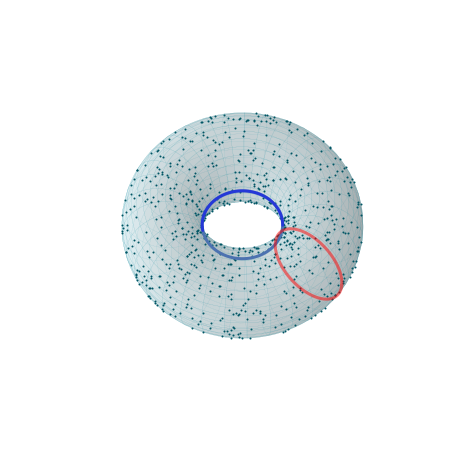

In [39]:
# sampling visual
geo_fig = plt.figure(figsize=(8,8))
ax = plt.gca(projection='3d')
ax.set_xlim(-1-r,1+r)
ax.set_ylim(-1-r,1+r)
ax.set_zlim(-1,1)
ax.set_facecolor('white')
ax.axis('off')


ax.plot_surface(x, y, z, color=cemm4, alpha=0.4, linewidth=0.1, edgecolors=cemm2 + [0.5])
ax.plot(pts[0],pts[1], pts[2], 'ko', markersize=1, color=cemm1);
# ax.plot(x12, y12, z12, 'b--', linewidth=3, alpha = 1);
ax.plot(x12, y12, z12, 'b', linewidth=3, alpha = 1);
ax.plot(x11, y11, z11, 'blue', linewidth=3, alpha = 0.5);
ax.plot(x2, y2, z2, 'red' , linewidth=3, alpha = 0.5);

ax.view_init(elev=60)

In [40]:
# network preprocessing
d = 0.6

D = squareform(pdist(np.array(pts).T))
A = np.where(np.abs(D)>d,0,1)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G)

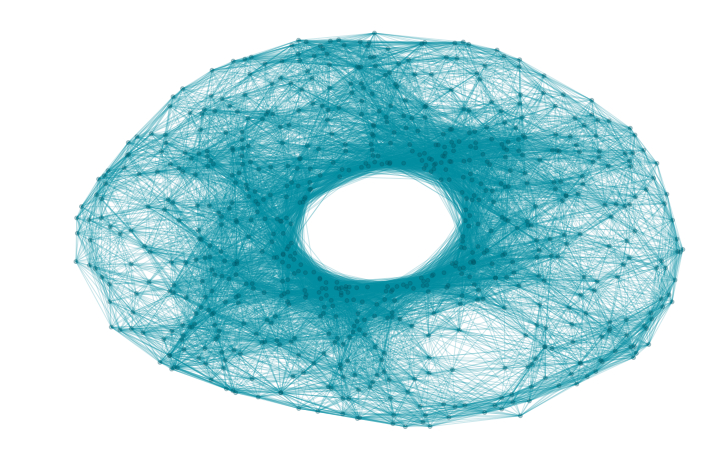

In [41]:
# network visuals
plot_nx(G, pos=pos)

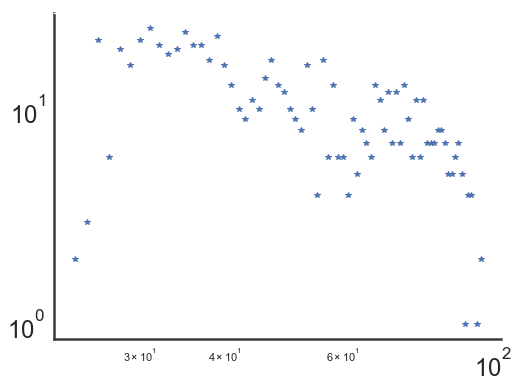

In [42]:
mode = 'loglog'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, '*', color=sblue)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/torus/torus_r{r:.2f}_d{d:.2f}_deg_{mode}.pdf', transparent=True)

In [37]:
# calclulate diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_d = rng.diagram(G, toa='toa')

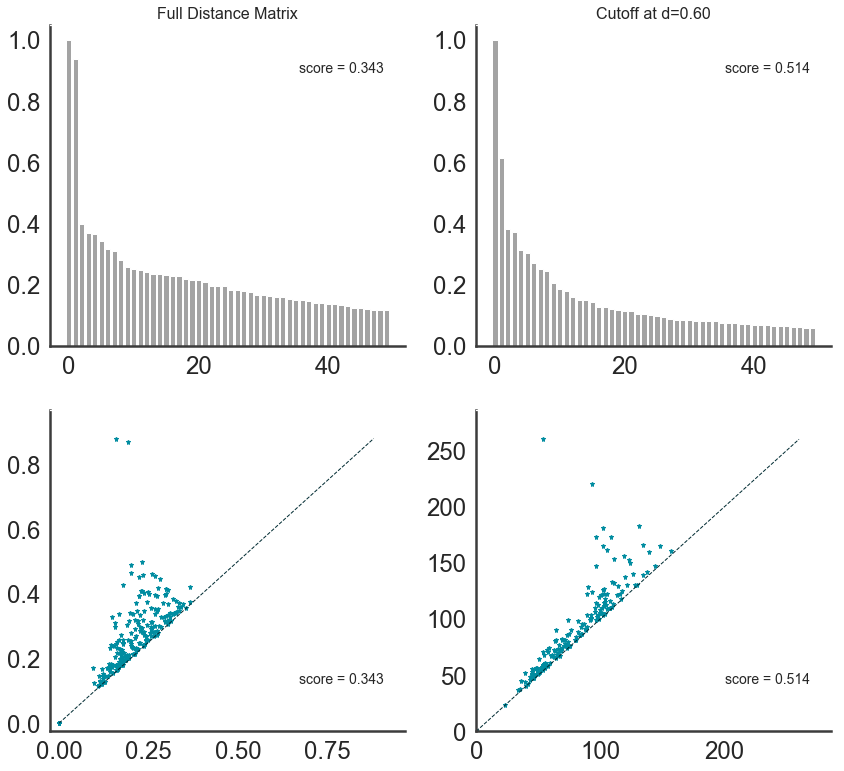

In [38]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at d={d:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_d, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_d, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);

### Save Data

In [39]:
# save data
np.savetxt(f'data/toy_networks/torus/torus_r{r:.2f}_D.txt', D)

dgm.save(  f'data/toy_networks/torus/torus_r{r:.2f}_dgm.csv')
dgm_d.save(f'data/toy_networks/torus/torus_r{r:.2f}_dgm_d.csv')

nx.write_edgelist(G, f'data/toy_networks/torus/torus_r{r:.2f}_d{d:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/toy_networks/torus/torus_r{r:.2f}_d{d:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_d, path=f'data/toy_networks/torus/torus_r{r:.2f}_d{d:.2f}_summary.html')

In [40]:
# save visuals
plot_dgm(dgm, path=f'data/toy_networks/torus/torus_r{r:.2f}_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/toy_networks/torus/torus_r{r:.2f}_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_d, path=f'data/toy_networks/torus/torus_r{r:.2f}_d{d:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_d, path=f'data/toy_networks/torus/torus_r{r:.2f}_d{d:.2f}_bar.pdf', silence=True, cap=30)
plot_nx(G,      path=f'data/toy_networks/torus/torus_r{r:.2f}_d{d:.2f}_nx.pdf',  silence=True, pos=pos)

geo_fig.savefig(f'data/toy_networks/torus/torus_r{r:.2f}_geometry2.pdf', transparent=True)
deg_fig.savefig(f'data/toy_networks/torus/torus_r{r:.2f}_d{d:.2f}_deg.pdf', transparent=True)

# Biological networks

## Lipids

In [235]:
# network preprocessing
c = 0.6

C = np.genfromtxt('data/biological_networks/lipids/lipid_corr.txt')
D = 1-np.abs(C)
A = np.where(np.abs(C)>c,1,0)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G)

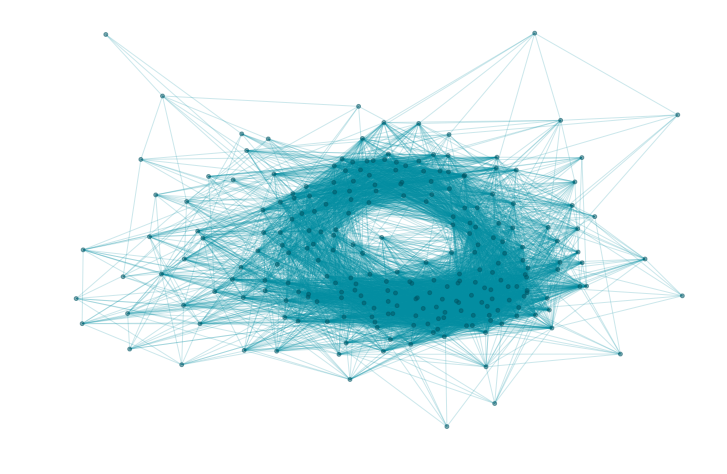

In [236]:
# network visuals
# pos = comb(pos) # moves sticky-out edges closer to the center
plot_nx(G, pos=pos, node_alpha=0.5)

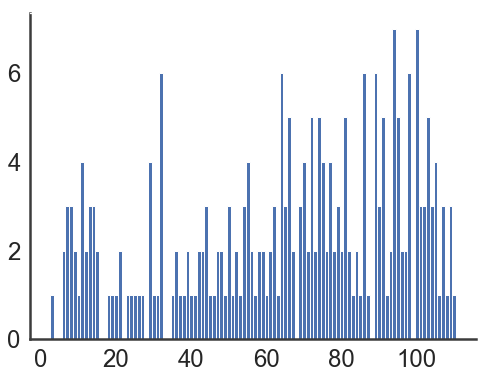

In [237]:
mode = 'bar'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, width=1, color=sblue)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/lipids/lipid_c{c:.2f}_deg_{mode}.pdf', transparent=True)

In [57]:
# calclulating diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_c = rng.diagram(G, toa='toa')

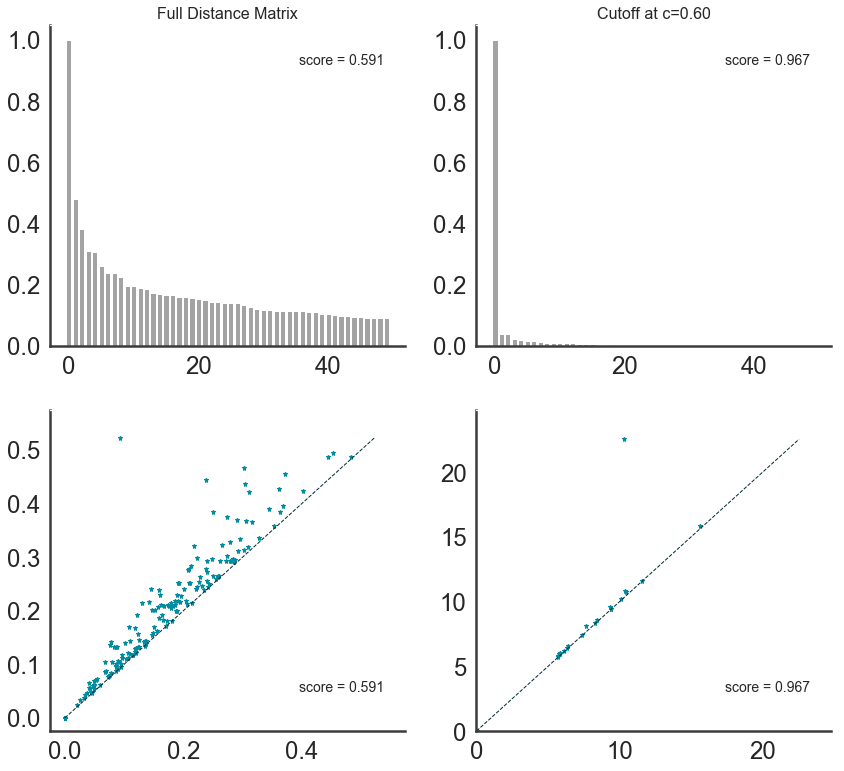

In [58]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_c, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_c, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save data

In [59]:
# save data
np.savetxt(f'data/biological_networks/lipids/lipid_D.txt', D)
np.savetxt(f'data/biological_networks/lipids/lipid_C.txt', C)

dgm.save(  f'data/biological_networks/lipids/lipid_dgm.csv')
dgm_c.save(f'data/biological_networks/lipids/lipid_c{c:.2f}_dgm.csv')

nx.write_edgelist(G, f'data/biological_networks/lipids/lipid_c{c:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/biological_networks/lipids/lipid_c{c:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_c, path=f'data/biological_networks/lipids/lipid_c{c:.2f}_summary.html')

In [61]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/lipids/lipid_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/lipids/lipid_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_d, path=f'data/biological_networks/lipids/lipid_c{c:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_d, path=f'data/biological_networks/lipids/lipid_c{c:.2f}_bar.pdf', silence=True, cap=30)
plot_nx(G,      path=f'data/biological_networks/lipids/lipid_c{c:.2f}_nx.pdf',  silence=True, pos=pos)

deg_fig.savefig(f'data/biological_networks/lipids/lipid_c{c:.2f}_deg.pdf', transparent=True)

## Genes
<center><h3 style="color:darkred"> >>> CAUTION - Big Data! <<<  </h3></center><p>

*Uncomment lines if the data is not produced yet.*

### Network processing

In [336]:
c = 0.95

# C = np.genfromtxt('data/biological_networks/genes/gene_corr.txt')
# D = 1-np.abs(C)
# A = np.where(np.abs(C)>c,1,0)
# np.fill_diagonal(A,0)
# G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

# for _, _, data in G.edges(data=True): data.pop('weight',None)
# nx.write_edgelist(G, f'data/biological_networks/genes/gene_c{c:.2f}_edgelist.csv', data=False)

### Network visuals - this might take a while ...    
&nbsp;&nbsp;&nbsp;&nbsp;(~15min on my computer)

*Load network for rerunning the visuals.*

In [337]:
G = nx.read_edgelist(f'data/biological_networks/genes/gene_c{c:.2f}_edgelist.csv', nodetype=int, data=False)

*Precompute/load layout positions.*

In [235]:
# pos = nx.spring_layout(G)
# with open(f'data/biological_networks/genes/gene_c{c:.2f}_pos.pkl', 'wb') as f:
#     pickle.dump(pos, f)

In [64]:
with open(f'data/biological_networks/genes/gene_c{c:.2f}_pos.pkl', 'rb') as f:
    pos = pickle.load(f)

*Plotting the network; this is the most time-consuming step. You might wanna save it right away.*

In [492]:
# pos = comb(pos)      # moves sticky-out edges closer to the center
# plot_nx(G, pos=pos)

*Save plot with precomputed layout positions.*

In [494]:
plot_nx(G, path=f'data/biological_networks/genes/gene_c{c:.2f}_nx.pdf',  silence=True, pos=pos)

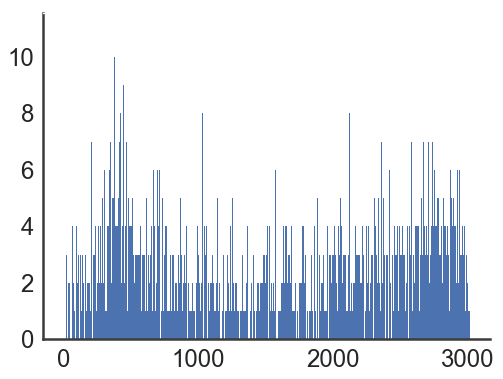

In [343]:
mode = 'bar'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, width=1, color=sblue, linewidth=0)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/genes/gene_c{c:.2f}_deg_{mode}.pdf', transparent=True)

In [66]:
deg_fig.savefig(f'data/biological_networks/genes/gene_c{c:.2f}_deg.pdf', transparent=True)

### Calculating diagrams - you probably won't be able to calculate this on a regular computer...    
&nbsp;&nbsp; (Some of these calculations require up to 256GB RAM and can long for up to 24h.)

In [57]:
# rng.induce_toa(G, split=10)
# nx.write_edgelist(G, f'data/biological_networks/genes/gene_c{c:.2f}_weightlist.csv')

In [58]:
# dgm = rng.diagram(G, toa='toa')
# dgm.save(f'data/biological_networks/genes/gene_c{c:.2f}_dgm.csv', )

In [59]:
# dgm = rng.ripser(D)
# dgm.save('data/biological_networks/genes/gene_dgm.csv')

In [214]:
dgm = rng.load_dgm('data/biological_networks/genes/gene_dgm.csv')
dgm_c = rng.load_dgm(f'data/biological_networks/genes/gene_c{c:.2f}_dgm.csv')

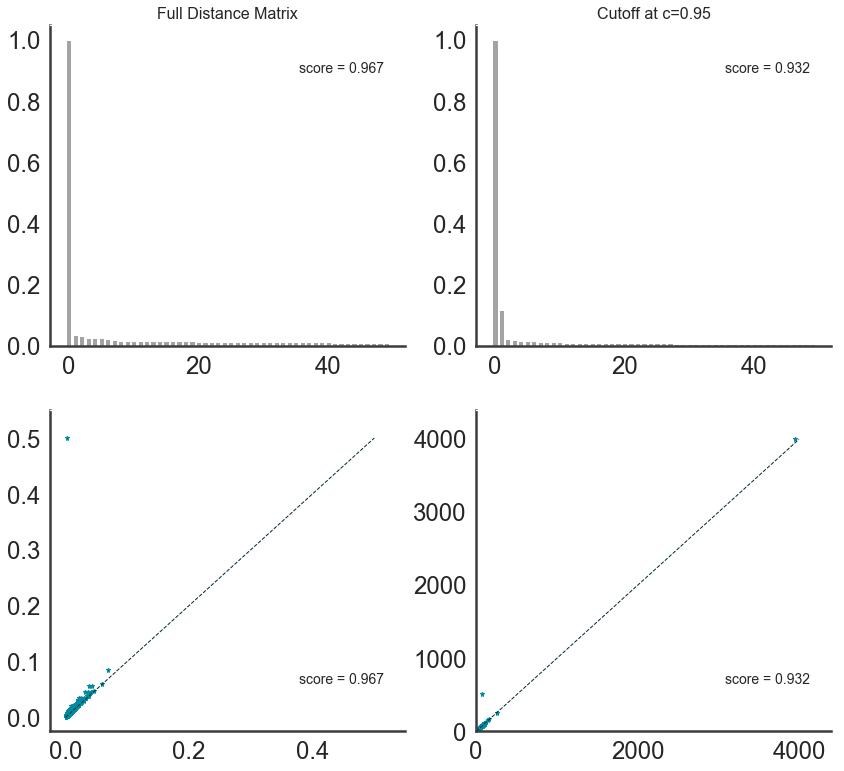

In [215]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_c, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_c, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);

### Write summary - this might take a while ...
&nbsp;&nbsp;&nbsp;&nbsp;(~12h/34h on my computer)

In [62]:
write_summary(G, dgm=dgm_c, path=f'data/biological_networks/genes/gene_c{c:.2f}_summary.html')

### Save persistent visuals

In [216]:
plot_dgm(dgm, path=f'data/biological_networks/genes/gene_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/genes/gene_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_c, path=f'data/biological_networks/genes/gene_c{c:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_c, path=f'data/biological_networks/genes/gene_c{c:.2f}_bar.pdf', silence=True, cap=30)

## Cells

In [22]:
# network preprocessing
d = 115

D = np.genfromtxt('data/biological_networks/cells/cell_D.txt')
A = np.where(np.abs(D)>d,0,1)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G)

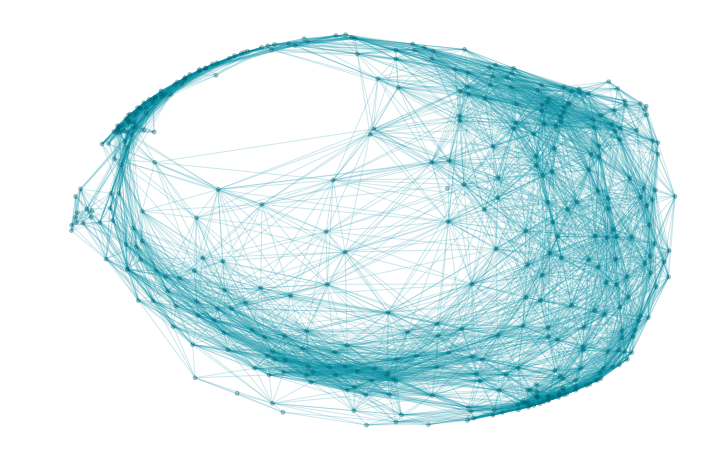

In [23]:
# network visuals
pos = comb(pos) # moves sticky-out edges closer to the center
plot_nx(G, pos=pos)

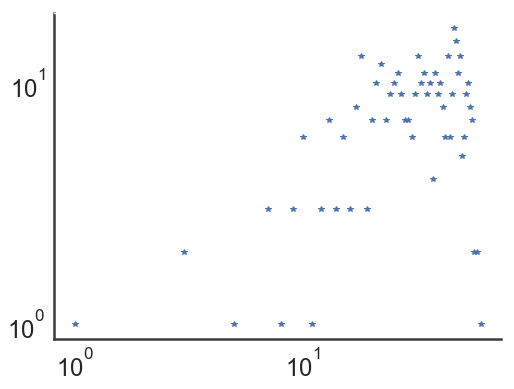

In [26]:
mode = 'loglog'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, '*', color=sblue, alpha=1)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/cells/cell_d{d:.2f}_deg_{mode}.pdf', transparent=True)

In [70]:
# calclulating diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_d = rng.diagram(G, toa='toa')

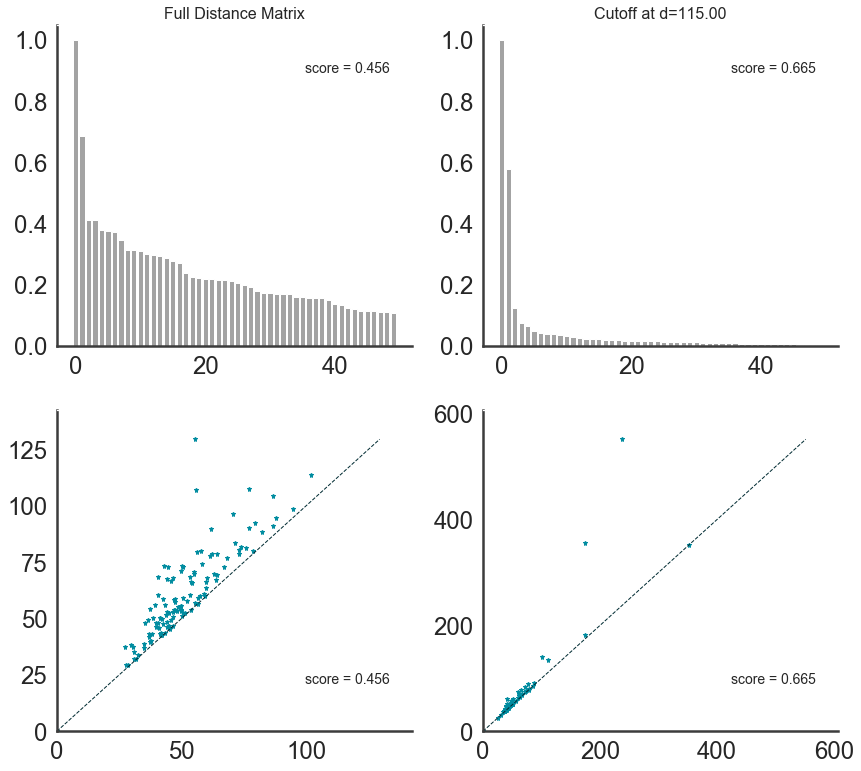

In [71]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at d={d:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_d, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_d, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);

### Save data

In [72]:
# save data
dgm.save(  f'data/biological_networks/cells/cell_dgm.csv')
dgm_d.save(f'data/biological_networks/cells/cell_d{d:.2f}_dgm.csv')

nx.write_edgelist(G, f'data/biological_networks/cells/cell_d{d:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/biological_networks/cells/cell_d{d:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_d, path=f'data/biological_networks/cells/cell_d{d:.2f}_summary.html')

In [73]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/cells/cell_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/cells/cell_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_d, path=f'data/biological_networks/cells/cell_d{d:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_d, path=f'data/biological_networks/cells/cell_d{d:.2f}_bar.pdf', silence=True, cap=30)
plot_nx(G,      path=f'data/biological_networks/cells/cell_d{d:.2f}_nx.pdf',  silence=True, pos=pos)

deg_fig.savefig(f'data/biological_networks/cells/cell_d{d:.2f}_deg.pdf', transparent=True)

## Soil

### MSE

In [34]:
# network preprocessing
d = 90

D = np.genfromtxt('data/biological_networks/soil/soil_gray_mse.txt')
A = np.where(np.abs(D)>d,0,1)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G, iterations=1000)

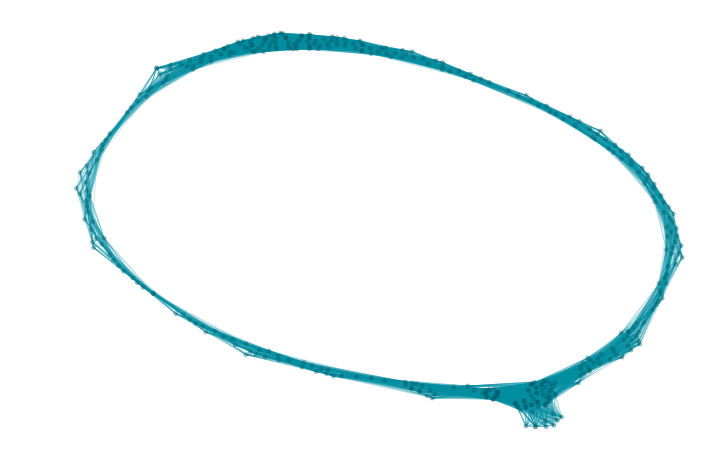

In [77]:
# network visuals
plot_nx(G, pos=pos)

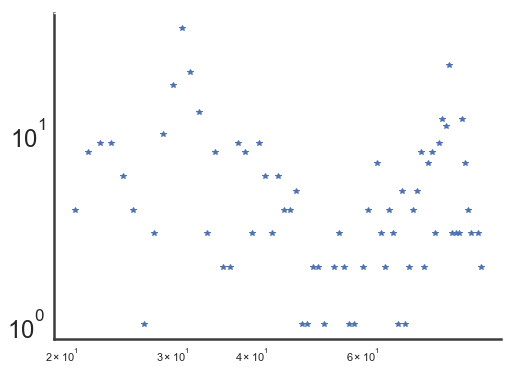

In [38]:
mode = 'loglog'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, '*', color=sblue)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/soil/soil_mse_d{d:.2f}deg_{mode}.pdf', transparent=True)

In [80]:
# calclulating diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_d = rng.diagram(G, toa='toa')

In [81]:
# add some vacuous points to the diagram to make the barplot look nicer
for i in range(10): dgm_d.append((0,0))

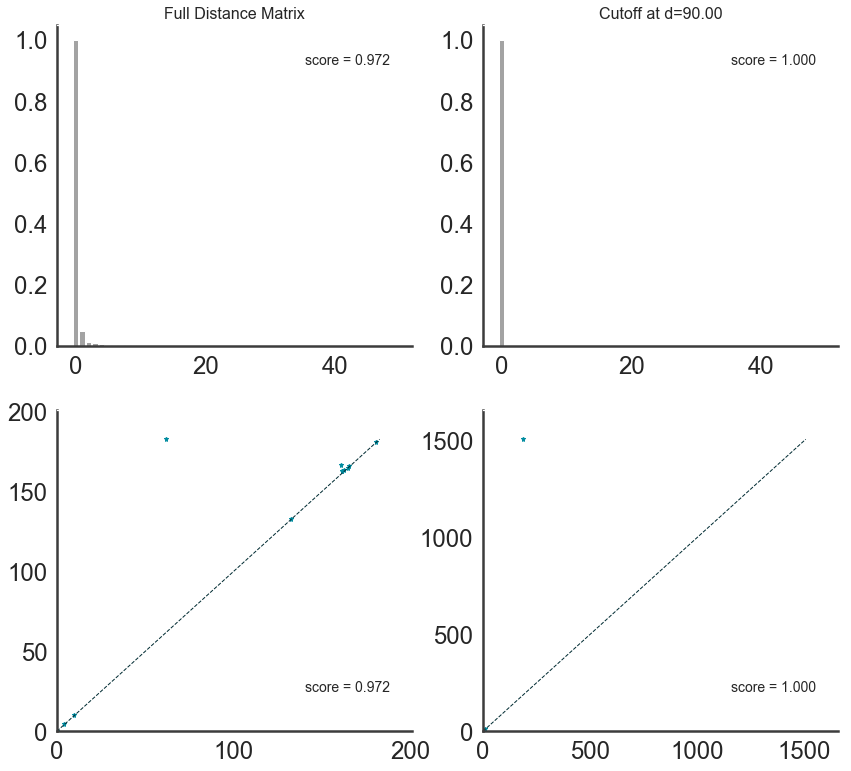

In [82]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at d={d:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_d, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_d, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save data

In [83]:
# save data
dgm.save(  f'data/biological_networks/soil/soil_mse_dgm.csv')
dgm_d.save(f'data/biological_networks/soil/soil_mse_d{d:.2f}_dgm.csv')

nx.write_edgelist(G, f'data/biological_networks/soil/soil_mse_d{d:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/biological_networks/soil/soil_mse_d{d:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_d, path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_summary.html')

In [84]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/soil/soil_mse_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/soil/soil_mse_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_d, path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_d, path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_bar.pdf', silence=True, cap=30)
plot_nx(G,      path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_nx.pdf',  silence=True, pos=pos)

deg_fig.savefig(f'data/biological_networks/soil/soil_mse_d{d:.2f}_deg.pdf', transparent=True)

### SSIM

In [161]:
# network preprocessing
c = 0.95

C = np.genfromtxt('data/biological_networks/soil/soil_gray_ssim.txt')
D = 1-np.abs(C)
A = np.where(np.abs(C)>c,1,0)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G)

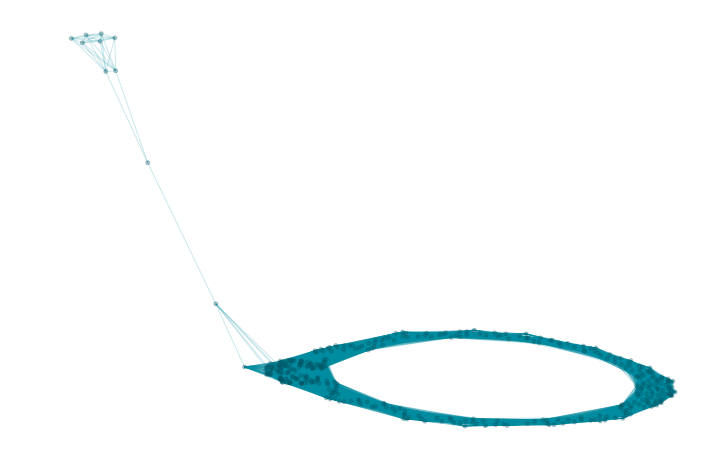

In [162]:
# network visuals
plot_nx(G, pos=pos)

In [163]:
# calclulating diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_c = rng.diagram(G, toa='toa')

In [167]:
# add some vacuous points to the diagram to make the barplot look nicer
for i in range(10): dgm.append((0,0))
for i in range(10): dgm_c.append((0,0))

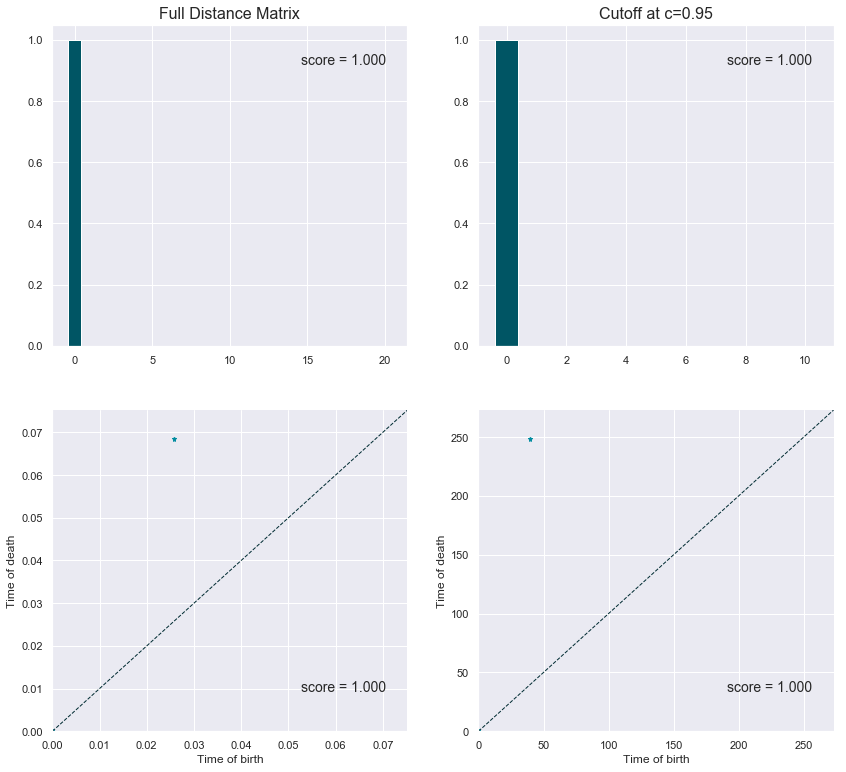

In [168]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_c, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_c, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save Data

In [171]:
# save data
dgm.save(  f'data/biological_networks/soil/soil_ssim_dgm.csv')
dgm_c.save(f'data/biological_networks/soil/soil_ssim_c{c:.2f}_dgm.csv')

nx.write_edgelist(G, f'data/biological_networks/soil/soil_ssim_c{c:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/biological_networks/soil/soil_ssim_c{c:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_c, path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_summary.html')

In [172]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/soil/soil_ssim_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/soil/soil_ssim_bar.pdf', silence=True, cap=50)

plot_dgm(dgm_c, path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_c, path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_bar.pdf', silence=True, cap=50)
plot_nx(G,      path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_nx.pdf',  silence=True, pos=pos)

## Interferons 

In [39]:
# network preprocessing
G = nx.read_edgelist('data/biological_networks/IFNs/IFN_edgelist.csv')
G = G.to_undirected()
G = max(nx.connected_component_subgraphs(G), key=len)
G = nx.convert_node_labels_to_integers(G)

pos = nx.spring_layout(G, iterations=1000)

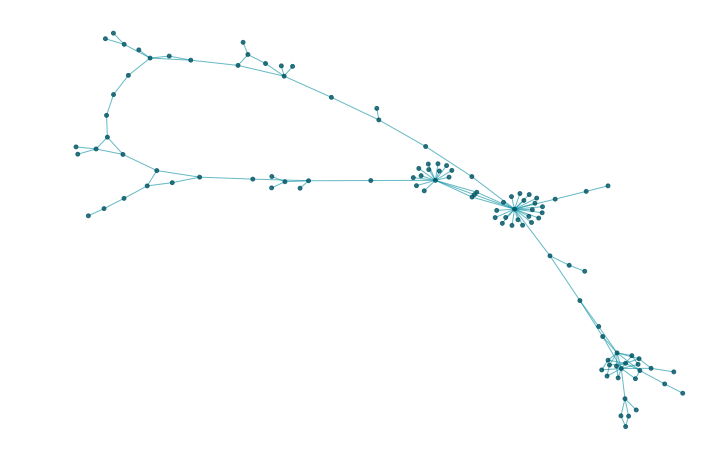

In [40]:
# network visuals
# pos = comb(pos) # moves sticky-out edges closer to the center
plot_nx(G, pos=pos, node_alpha=0.8, edge_alpha=0.6)

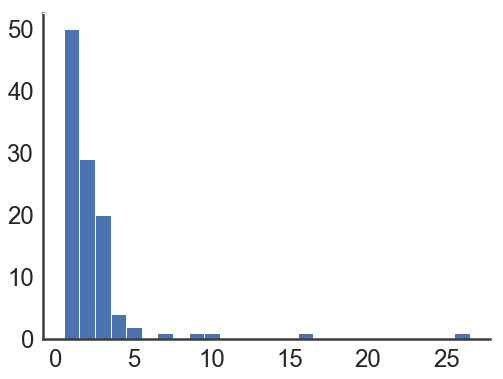

In [44]:
mode = 'bar'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, width=1, color=sblue)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/IFNs/IFN_deg_{mode}.pdf', transparent=True)

In [88]:
# calclulating diagrams
rng.induce_toa(G)
dgm = rng.diagram(G, toa='toa')

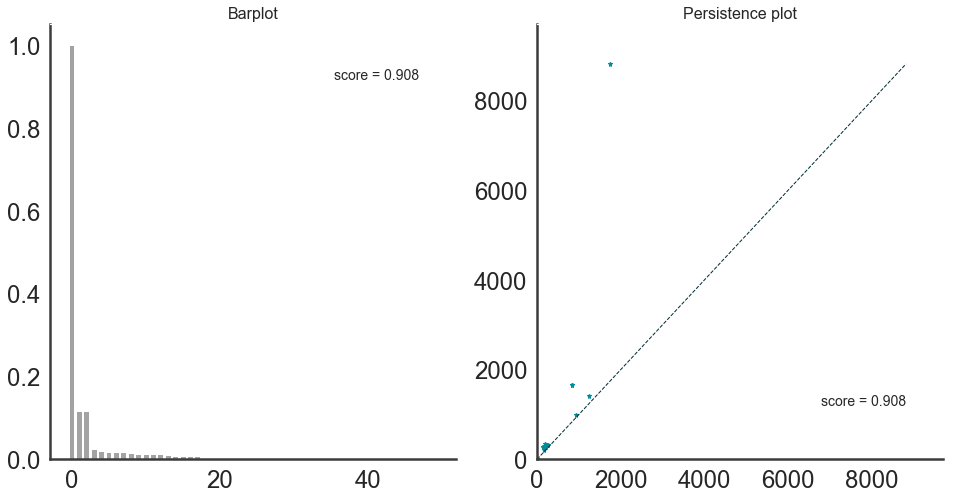

In [89]:
# persistence visuals
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].set_title('Barplot', fontsize=16)
axes[1].set_title('Persistence plot', fontsize=16)

plot_bar(dgm, ax=axes[0], cap=50)
plot_dgm(dgm, ax=axes[1])

axes[0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save data

In [90]:
# save data
dgm.save(  f'data/biological_networks/IFNs/IFN_dgm.csv')
nx.write_edgelist(G, f'data/biological_networks/IFNs/IFN_weightlist.csv')
write_summary(G, dgm, path=f'data/biological_networks/IFNs/IFN_summary.html')

In [91]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/IFNs/IFN_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/IFNs/IFN_bar.pdf', silence=True, cap=30)
plot_nx(G,    path=f'data/biological_networks/IFNs/IFN_nx.pdf',  silence=True, 
        pos=pos, node_alpha=0.8, edge_alpha=0.6)

deg_fig.savefig(f'data/biological_networks/IFNs/IFN_deg.pdf', transparent=True)

# Synthetic networks

## Watts-Strogatz (individuals)

In [49]:
# Set parameters
N = 1000
k = 10

p_list = [0, 0.01, 0.1, 1]
G_list = [nx.watts_strogatz_graph(N,k,p) for p in p_list]

pos = {n:(np.cos(t), np.sin(t)) for (n,t) in enumerate(np.linspace(0,2*np.pi,N+1))}

In [50]:
# get those data!
path = f'data/toy_networks/watts_strogatz/dgms/N{N}/k{k}'
dgm_dict = {p:[] for p in p_list}

for p in p_list:
    for file in os.listdir(f'{path}/p{p:.6f}'):
        if not file.endswith('.csv'):
            continue
        dgm = rng.load_dgm(f'{path}/p{p:.6f}/{file}')
        for i in range(50): dgm.append((0,0))
        dgm_dict[p].append(rng.normalize(dgm))
        
dgm_list = [np.mean(dgm_dict[p]) for p in p_list]

In [51]:
# somehow for p=0 things don't work properly...
file = os.listdir(f'{path}/p{0:.6f}')[0]
dgm = rng.load_dgm(f'{path}/p{0:.6f}/{file}')
dgm_list[0] = rng.normalize(dgm)

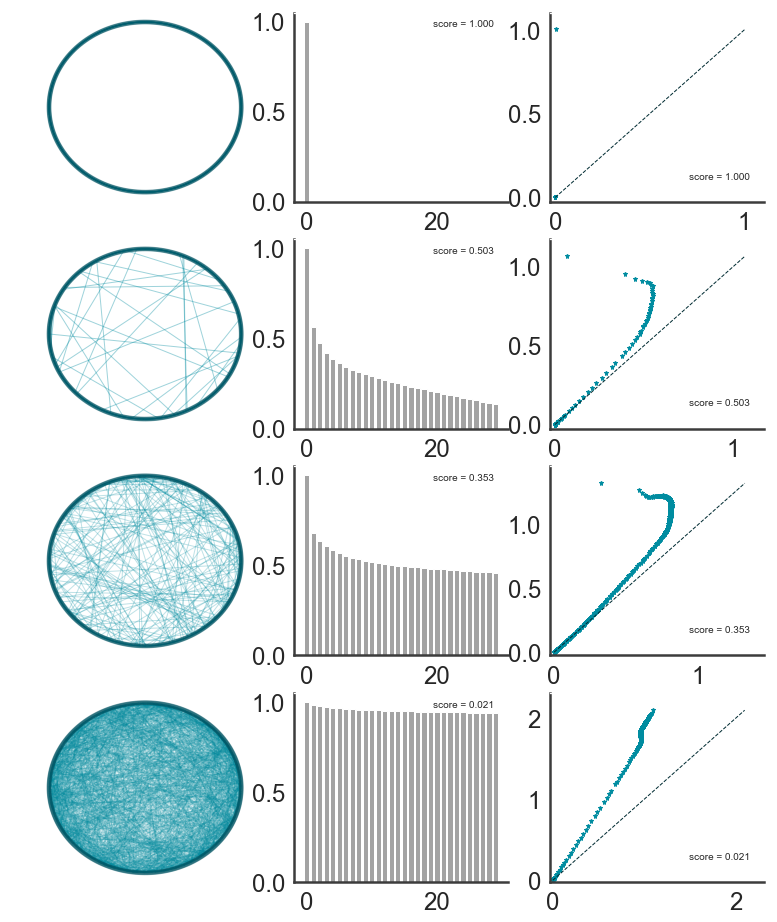

In [237]:
# persistence visuals
fig, axes = plt.subplots(len(p_list), 3, figsize=(13,16))

for i in range(len(p_list)):
    plot_nx(G_list[i], pos=pos, ax=axes[i,0], edge_alpha=(1-i/4)/2)
    plot_bar(dgm_list[i], ax=axes[i,1], cap=30)
    plot_dgm(dgm_list[i], ax=axes[i,2])
    
    axes[i,1].annotate(f'score = {dgm_list[i].GGS:.3f}', xy=(0.65, 0.925), xycoords='axes fraction', fontsize=10);
    axes[i,2].annotate(f'score = {dgm_list[i].GGS:.3f}', xy=(0.65, 0.12), xycoords='axes fraction', fontsize=10);

### Save data

In [92]:
# save visuals

for i,p in enumerate(p_list):
    plot_dgm(dgm_list[i], path=f'data/toy_networks/watts_strogatz/figures/N{N}_k{k}_p{p:.6f}_dgm.pdf', silence=True)
    plot_bar(dgm_list[i], path=f'data/toy_networks/watts_strogatz/figures/N{N}_k{k}_p{p:.6f}_bar.pdf', silence=True, cap=30)
    plot_nx(G_list[i], pos=pos, path=f'data/toy_networks/watts_strogatz/figures/N{N}_k{k}_p{p:.6f}_nx.pdf', silence=True)

NameError: name 'p_list' is not defined

## Watts-Strogatz (curves)

In [52]:
# Some preprocessing
N = 2**10

k_list = [8, 10, 12]
p_lists = []
score_lists = []

for k in k_list:
    df = pd.read_csv(f'data/toy_networks/watts_strogatz/GGS/N{N}/k{k}/GGS.csv', index_col=0).mean()
    p_lists.append(np.array(df.index.astype(float)))
    score_lists.append(np.array(df))

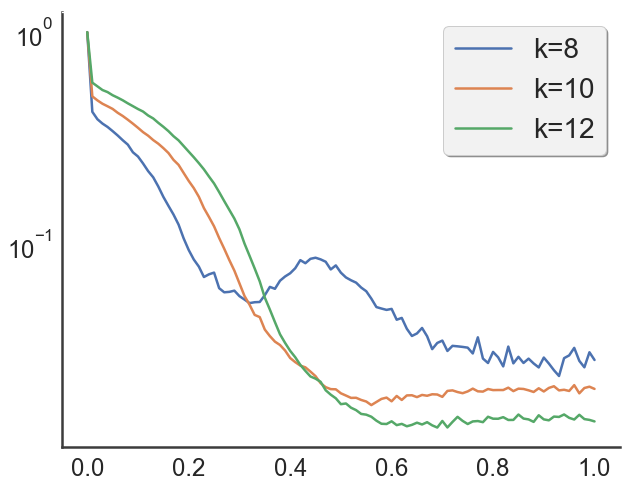

In [120]:
# Aaaand here the visuals
rand_fig, ax = plt.subplots(figsize=(10,8))
rand_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

for i,k in enumerate(k_list):
    ax.semilogy(p_lists[i], score_lists[i], label=f'k={k}', linewidth=2.5)
    
ax.legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0])
# ax.set_title(f'Watts-Strogatz scores for N={N}', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

### Save Data

In [121]:
rand_fig.savefig('data/toy_networks/watts_strogatz/figures/randomness_plot.pdf')

## Erdos-Renyi (annealing)

In [8]:
# Some preprocessing
N = 2**8
df = pd.read_csv(f'data/toy_networks/erdos_renyi/ER_analysis/GGS/{N}.csv', index_col=0)
df.columns = df.columns.astype(float)

dfa = pd.read_csv(f'data/toy_networks/erdos_renyi/ER_annealing_10000/GGS/{N}.csv', index_col=0)
dfa.columns = dfa.columns.astype(float)

df = df.iloc[:,df.columns<=0.1]

x      = np.array(list(map(float,df.keys())))
y_25   = np.array(df.describe().loc['25%'])
y_mean = np.array(df.describe().loc['mean'])
y_75   = np.array(df.describe().loc['75%'])

xa      = np.array(list(map(float,dfa.keys())))
ya_25   = np.array(dfa.describe().loc['25%'])
ya_mean = np.array(dfa.describe().loc['mean'])
ya_75   = np.array(dfa.describe().loc['75%'])

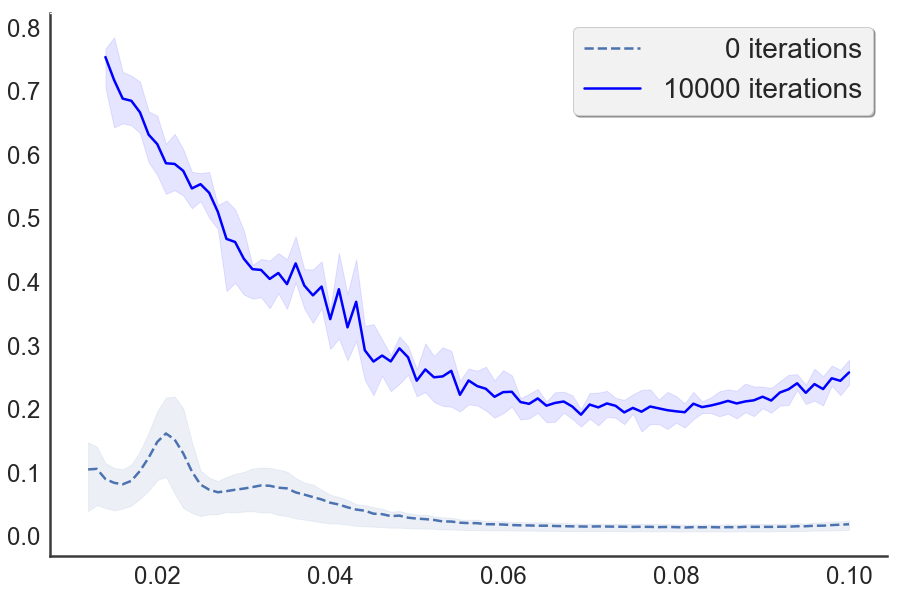

In [9]:
dens_fig, ax = plt.subplots(figsize=(15,10))
dens_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.plot(x, y_mean,'--', label='        0 iterations', color=sblue, linewidth=2.5);
ax.fill_between(x, y_25 , y_75 , alpha=0.1, color=sblue);

ax.plot(xa, ya_mean, color='blue', label='10000 iterations', linewidth=2.5);
ax.fill_between(xa, ya_25 , ya_75 , alpha=0.1, color='blue');

# ax.set_xlabel('density')
# ax.set_ylabel('score')
ax.legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0])
# ax.set_title(r'ER$\left(2^8,p\right)$ annealed scores', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

In [10]:
p = '0.090000'
path = f'data/toy_networks/erdos_renyi/ER_annealing_10000/datas/N{N}/p{p}'
data = np.zeros(10000)

for i, file in enumerate(os.listdir(f'{path}')):
    data += np.genfromtxt(f'{path}/{file}')
data = data/i

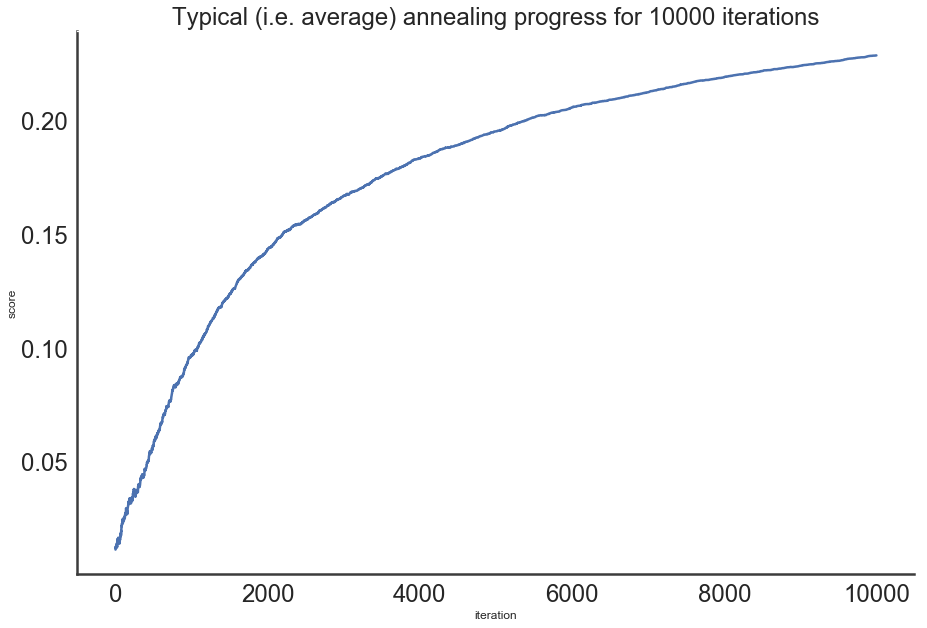

In [11]:
iter_fig, ax = plt.subplots(figsize=(15,10))
iter_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.plot(data, linewidth=2.5);
ax.set_xlabel('iteration')
ax.set_ylabel('score')
ax.set_title('Typical (i.e. average) annealing progress for 10000 iterations', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

### Save data

In [12]:
dens_fig.savefig('data/toy_networks/erdos_renyi/figures/density_plot.pdf')
iter_fig.savefig('data/toy_networks/erdos_renyi/figures/iteration_plot.pdf')

## Erdos_Renyi (density)

In [280]:
N = 2**7
df0 = pd.read_csv(f'data/toy_networks/erdos_renyi/ER_analysis/GGS/{N}.csv', index_col=0)
df0.columns = df0.columns.astype(float)

N = 2**8
df1 = pd.read_csv(f'data/toy_networks/erdos_renyi/ER_analysis/GGS/{N}.csv', index_col=0)
df1.columns = df1.columns.astype(float)

N = 2**9
df2 = pd.read_csv(f'data/toy_networks/erdos_renyi/ER_analysis/GGS/{N}.csv', index_col=0)
df2.columns = df2.columns.astype(float)

N = 2**10
df3 = pd.read_csv(f'data/toy_networks/erdos_renyi/ER_analysis/GGS/{N}.csv', index_col=0)
df3.columns = df3.columns.astype(float)

## Barabasi-Albert (annealing)

In [13]:
N = 2**8

df = pd.read_csv(f'data/toy_networks/barabasi_albert/BA_analysis/GGS/{N}.csv', index_col=0)
df.columns = df.columns.astype(int)

dfa = pd.read_csv(f'data/toy_networks/barabasi_albert/BA_annealing_10000/GGS/{N}.csv', index_col=0)
dfa.columns = dfa.columns.astype(int)

df  = df.iloc[:,df.columns   < 14]
dfa = dfa.iloc[:,dfa.columns < 14]

x      = np.array(list(map(int,df.keys())))
y_25   = np.array(df.describe().loc['25%'])
y_mean = np.array(df.describe().loc['mean'])
y_75   = np.array(df.describe().loc['75%'])

xa      = np.array(list(map(int,dfa.keys())))
ya_25   = np.array(dfa.describe().loc['25%'])
ya_mean = np.array(dfa.describe().loc['mean'])
ya_75   = np.array(dfa.describe().loc['75%'])

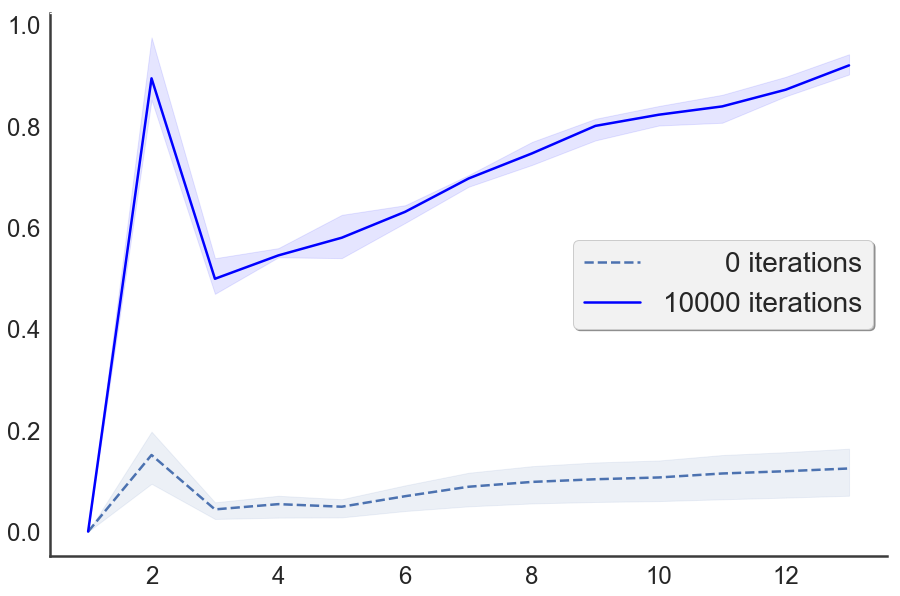

In [14]:
dens_fig, ax = plt.subplots(figsize=(15,10))
dens_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.plot(x, y_mean,'--', label='        0 iterations', color=sblue, linewidth=2.5);
ax.fill_between(x, y_25 , y_75 , alpha=0.1, color=sblue);

ax.plot(xa, ya_mean, color='blue', label='10000 iterations', linewidth=2.5);
ax.fill_between(xa, ya_25 , ya_75 , alpha=0.1, color='blue');

# ax.set_xlabel('m')
# ax.set_ylabel('score')
ax.legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0])
# ax.set_title(r'BA$\left(2^8,p\right)$ annealed scores', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

In [15]:
m = 4
path = f'data/toy_networks/barabasi_albert/BA_annealing_10000/datas/N{N}/m{m}'
data = np.zeros(10000)

for i, file in enumerate(os.listdir(f'{path}')):
    data += np.genfromtxt(f'{path}/{file}')
data = data/i

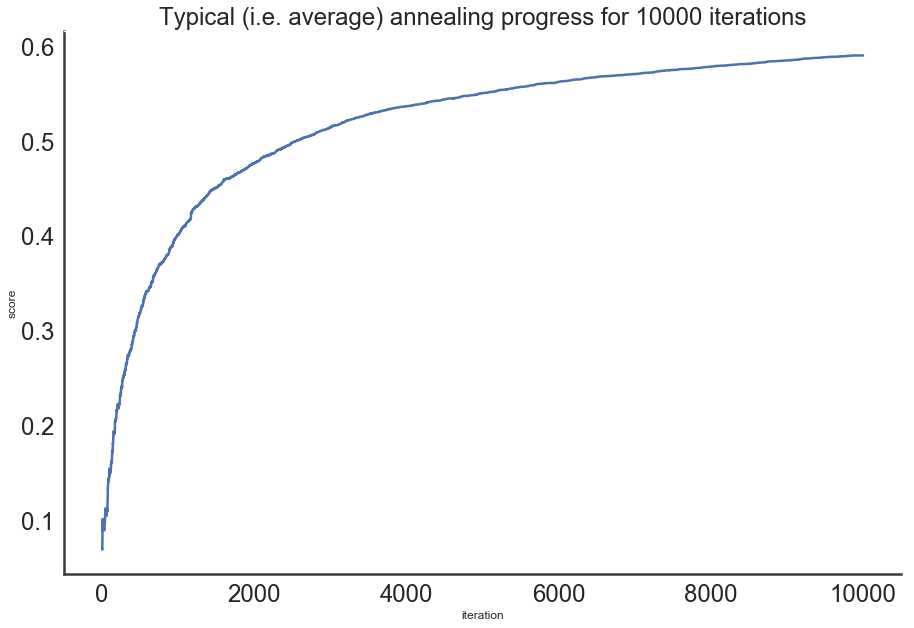

In [16]:
iter_fig, ax = plt.subplots(figsize=(15,10))
iter_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.plot(data, linewidth=2.5);
ax.set_xlabel('iteration')
ax.set_ylabel('score')
ax.set_title('Typical (i.e. average) annealing progress for 10000 iterations', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

### Save Data

In [17]:
dens_fig.savefig('data/toy_networks/barabasi_albert/figures/density_plot.pdf')
iter_fig.savefig('data/toy_networks/barabasi_albert/figures/iteration_plot.pdf')